# Data Processing

In [1]:
import pandas as pd
import numpy as np
import os
import cpi
import rasterio
from rasterio.mask import mask
import zipfile

import geopandas as gpd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,}'.format

/var/folders/ql/2vqj8p0d1gq1gggdp2dycp5c0000gn/T/ipykernel_10430/1685008173.py:4: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  import cpi


In [2]:
# Helper function to convert source data to right format
def currency_to_number(currency_val):
    if isinstance(currency_val, str):
        return pd.to_numeric(currency_val.replace('$', '').replace(',', ''), errors='coerce')
    return currency_val

In [3]:
os.chdir('/Users/hashim/Library/Mobile Documents/com~apple~CloudDocs/ust/seis732-data stores and feature design/project/city_employment')
path_to_data_folder = os.listdir('/Users/hashim/Library/Mobile Documents/com~apple~CloudDocs/ust/seis732-data stores and feature design/project/city_employment')
path_to_data_folder.remove('.DS_Store')

In [4]:
# Here is the directory structure of our data
path_to_data_folder

['55407',
 'mpls_zipcode_employment_summary.csv',
 '55406',
 '55413,18,21',
 '55412,30',
 '55405,08,16',
 '55414,55',
 '55401-04;15,54,87,88',
 '55409,10,19',
 '55411',
 '55417']

In [5]:
# This is the naming convention we have employed 
# so we are able to consolidate the data easily
os.listdir('55407/')

['2008.csv',
 '2020.csv',
 '2021.csv',
 '2009.csv',
 '2022.csv',
 '2019.csv',
 '2018.csv',
 '2001.csv',
 '2015.csv',
 '2014.csv',
 '2000.csv',
 '2016.csv',
 '2002.csv',
 '2003.csv',
 '2017.csv',
 '2013.csv',
 '2007.csv',
 '2006.csv',
 '2012.csv',
 '2004.csv',
 '2010.csv',
 '2011.csv',
 '2005.csv']

In [6]:
df = pd.read_csv('55406/2003.csv', delimiter='\t', encoding='utf-16-le', skiprows=2)

## Preview of one source file for our primary data (employment by industry and zip)

### Below is one source file. I had to extract 230 csv files. We are looking to use Python to consolidate this into one Pandas DataFrame consisting of 230 rows. 

In [7]:
df.head(3)

,NAICS,Industry Title,Employment,Establishments,Avg. Annual Wage,Total Payroll
0,238,Specialty Trade Contractors,353,38.0,"$42,744","$15,276,341"
1,311,Food Manufacturing,260,5.0,"$37,596","$9,763,310"
2,323,Printing and Related Support Activities,247,9.0,"$50,128","$12,379,716"


## Let's consolidate these 

In [8]:
# Initialize a list to store the summary data
summary_data = []

# Iterate over each folder
for zipcode_folder in path_to_data_folder:
    zipcode = zipcode_folder    
    folder_path = zipcode_folder

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Iterate over each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                year = file.split('.')[0]
                file_path = os.path.join(folder_path, file)

                # Read the CSV file
                df = pd.read_csv(file_path, delimiter='\t', encoding='utf-16-le', skiprows=2)
                df = df.fillna(0)
                
                try:
                    df['Employment'] = df['Employment'].astype(int)
                except Exception:
                    df['Employment'] = df['Employment'].str.replace(',','').fillna(0).astype(int)
                
                try:
                    df['Establishments'] = df['Establishments'].astype(int)
                except Exception:
                    df['Establishments'] = df['Establishments'].str.replace(',','').fillna(0).astype(int)
                
                df['Avg. Annual Wage'] = df['Avg. Annual Wage'].str.replace('$', '').str.replace(',', '').fillna(0).astype(float)
                df['Total Payroll'] = df['Total Payroll'].str.replace('$', '').str.replace(',', '').fillna(0).astype(float)
                
                           
                # Total Employment in Zipcode
                total_employment = df['Employment'].sum()
                total_establishments = df['Establishments'].sum()
                total_payroll = df['Total Payroll'].sum()

                # Filter for NAICS 722
                df_722 = df[df['NAICS'] == 722]

                # Check if NAICS 722 data is available
                if not df_722.empty:
                    employment_722 = df_722['Employment'].sum()
                    establishments_722 = df_722['Establishments'].sum()
                    avg_wage_722 = df_722['Avg. Annual Wage'].sum()
                    total_payroll_722 = df_722['Total Payroll'].sum()
                else:
                    employment_722 = 0
                    establishments_722 = 0
                    avg_wage_722 = 0
                    total_payroll_722 = 0

                # Append the data to the summary list
                summary_data.append({
                    'Zipcode': zipcode,
                    'Year': year,
                    'Total Employment in Zipcode': total_employment,
                    'Total Establishments in Zipcode': total_establishments,
                    'Total Payroll in Zipcode': total_payroll,
                    'Employment for NAICS 722': employment_722,
                    'Establishments for NAICS 722': establishments_722,
                    'Avg. Annual Wage for NAICS 722': avg_wage_722,
                    'Total Payroll for NAICS 722': total_payroll_722
                })

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(summary_data)

In [9]:
summary_df.sort_values('Zipcode').head()

,Zipcode,Year,Total Employment in Zipcode,Total Establishments in Zipcode,Total Payroll in Zipcode,Employment for NAICS 722,Establishments for NAICS 722,Avg. Annual Wage for NAICS 722,Total Payroll for NAICS 722
140,"55401-04;15,54,87,88",2021,148201,4159,"16,292,541,001.0",6243,405,"30,004.0","190,986,359.0"
139,"55401-04;15,54,87,88",2020,148898,4189,"15,380,483,441.0",5617,418,"27,456.0","153,933,482.0"
141,"55401-04;15,54,87,88",2009,146088,4314,"9,960,902,372.0",8652,373,"18,148.0","157,317,173.0"
142,"55401-04;15,54,87,88",2022,153292,4379,"17,291,375,031.0",7993,403,"32,708.0","262,605,818.0"
143,"55401-04;15,54,87,88",2019,164357,4239,"15,465,370,734.0",10854,429,"26,832.0","291,761,862.0"


In [ ]:
#summary_df.to_csv('mpls_zipcode_employment_summary.csv',index=False)

## Summary data fields

In [10]:
summary_df.columns

Index(['Zipcode', 'Year', 'Total Employment in Zipcode',
       'Total Establishments in Zipcode', 'Total Payroll in Zipcode',
       'Employment for NAICS 722', 'Establishments for NAICS 722',
       'Avg. Annual Wage for NAICS 722', 'Total Payroll for NAICS 722'],
      dtype='object')

- 'Zipcode',
- 'Year',
- 'Total Employment in Zipcode',
- 'Total Establishments in Zipcode',
- 'Total Payroll in Zipcode',
- 'Employment for NAICS 722',
- 'Establishments for NAICS 722',
- 'Avg. Annual Wage for NAICS 722',
- 'Total Payroll for NAICS 722'


This is the data we have described in the data dictionary

# Data Merging 

In [11]:
os.chdir('/Users/hashim/Library/Mobile Documents/com~apple~CloudDocs/ust/seis732-data stores and feature design/project')

## Read in our summary data (primary) that we created above

In [12]:
df_employment = pd.read_csv('city_employment/mpls_zipcode_employment_summary.csv')

## Read in our time series data

- Average price of rice per lb by month and year
- Average price of flour per lb by month and year


In [13]:
df_flour = pd.read_excel('raw data/flour_midwest_avg_price_not_seasonally_adjusted.xlsx', skiprows=9)
df_rice = pd.read_excel('raw data/rice_midwest_avg_price_not_seasonally_adjusted.xlsx', skiprows=9)

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [14]:
df_flour.head(3)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1990,0.253,0.249,0.252,0.251,0.254,0.259,0.26,0.255,0.249,0.244,0.235,0.236
1,1991,0.244,0.235,0.235,0.237,0.235,0.237,0.239,0.238,0.232,0.23,0.218,0.223
2,1992,0.241,0.244,0.239,0.238,0.245,0.244,0.252,0.256,0.249,0.241,0.234,0.233


In [15]:
df_rice.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1990,0.501,0.476,0.502,0.497,0.496,0.494,0.494,0.497,0.505,0.497,0.507,0.491
1,1991,0.494,0.492,0.498,0.502,0.502,0.506,0.503,0.494,0.506,0.508,0.517,0.51
2,1992,0.516,0.515,0.515,0.522,0.524,0.52,0.54,0.537,0.542,0.543,0.536,0.525
3,1993,0.526,0.53,0.525,0.522,0.518,0.518,0.527,0.507,0.494,0.495,0.49,0.495
4,1994,0.515,0.543,0.556,0.575,0.562,0.555,0.566,0.546,0.534,0.534,0.541,0.534


## Caveat Note: 

There is no data for 2001 and some months are missing for 2000 and 2002 for rice data. 

I am going to take the average of 2000 and 2002 and just add it in there

In [16]:
df_rice[df_rice['Year'].isin([2000, 2001 ,2002])]

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
10,2000,0.499,0.492,0.481,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2002,NaN,NaN,NaN,NaN,0.472,0.47,0.475,0.482,0.471,0.466,0.461,0.458


In [17]:
df_rice.loc[10:11]

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
10,2000,0.499,0.492,0.481,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2002,NaN,NaN,NaN,NaN,0.472,0.47,0.475,0.482,0.471,0.466,0.461,0.458


## Workaround 

Take mean of this

In [18]:
df_rice.loc[10:11].mean()['Jan':'Dec'].mean()

0.4764166666666667

In [19]:
# New row data for the year 2001 with all months having a value of 0.476
new_row = {'Year': 2001, 'Jan': 0.476, 'Feb': 0.476, 'Mar': 0.476, 'Apr': 0.476, 'May': 0.476, 
           'Jun': 0.476, 'Jul': 0.476, 'Aug': 0.476, 'Sep': 0.476, 'Oct': 0.476, 'Nov': 0.476, 'Dec': 0.476}

In [20]:
df_rice = pd.concat([df_rice, pd.DataFrame([new_row])], ignore_index=True)

In [21]:
df_rice.sort_values('Year', inplace=True)
df_rice.reset_index(drop=True, inplace=True)

## Consolidate the rice and flour data

Since this data is not in the same granularity (i.e broken down by month) as our primary data (broken down by year), we need to aggregate this so we can join on the `Year` field.

### How are we going to aggregate ? 
- Take the mean of each year

In [22]:
years = pd.Series(list(range(1990,2024)))

# We are going to take the mean of each year and that 
flour_avg_price = df_flour.T.loc['Jan':'Dec',].mean()
rice_avg_price = df_rice.T.loc['Jan':'Dec', ].mean()

In [23]:
years.name = 'Year'
flour_avg_price.name = 'Flour Avg Price per lb'
rice_avg_price.name = 'Rice Avg Price per lb'

In [24]:
df_avg_price = pd.concat([years, flour_avg_price, rice_avg_price],axis=1)

In [25]:
pd.options.display.float_format = '{:,.2f}'.format

In [26]:
df_avg_price.head()

,Year,Flour Avg Price per lb,Rice Avg Price per lb
0,1990,0.25,0.50
1,1991,0.23,0.50
2,1992,0.24,0.53
3,1993,0.23,0.51
4,1994,0.23,0.55


## Join primary and time series data

In [27]:
df_merged = pd.merge(df_employment, df_avg_price, on=['Year'], how='inner')

In [28]:
df_merged.head()

,Zipcode,Year,Total Employment in Zipcode,Total Establishments in Zipcode,Total Payroll in Zipcode,Employment for NAICS 722,Establishments for NAICS 722,Avg. Annual Wage for NAICS 722,Total Payroll for NAICS 722,Flour Avg Price per lb,Rice Avg Price per lb
0,55407,2008,6077,416,"350,163,127.00",473,53,"14,404.00","6,822,473.00",0.51,0.73
1,55406,2008,5685,449,"206,421,620.00",925,62,"13,884.00","12,881,469.00",0.51,0.73
2,"55413,18,21",2008,25961,1211,"1,291,854,067.00",0,0,0.00,0.00,0.51,0.73
3,"55412,30",2008,1545,116,"60,056,841.00",0,0,0.00,0.00,0.51,0.73
4,"55405,08,16",2008,9958,1069,"383,932,010.00",0,0,0.00,0.00,0.51,0.73


## Feature Engineering

Going to calculate number of food service jobs in each zip code by year. 

In [29]:
df_merged['% Food Service Jobs in Zip'] = df_merged['Employment for NAICS 722']/df_merged['Total Employment in Zipcode']
df_merged['% Food Service Establishments in Zip'] = df_merged['Establishments for NAICS 722']/df_merged['Total Establishments in Zipcode']

df_merged = df_merged.sort_values(by=['Zipcode', 'Year']).reset_index(drop=True)

For our hypothetical analysis we are going to calculate percentage change year over year grouped by Zip code. Below are the fields where we are going to calculate percentage change.

In [30]:
columns_to_calculate = [
    'Total Employment in Zipcode', 
    'Total Establishments in Zipcode', 
    'Total Payroll in Zipcode', 
    'Employment for NAICS 722', 
    'Establishments for NAICS 722', 
    'Avg. Annual Wage for NAICS 722', 
    'Total Payroll for NAICS 722'
]

In [31]:
df_merged.fillna(0,inplace=True)

In [32]:
for column in columns_to_calculate:
    df_merged[column + ' Yearly % Change'] = df_merged.groupby('Zipcode')[column].pct_change() * 1

In [33]:
df_merged.head()

,Zipcode,Year,Total Employment in Zipcode,Total Establishments in Zipcode,Total Payroll in Zipcode,Employment for NAICS 722,Establishments for NAICS 722,Avg. Annual Wage for NAICS 722,Total Payroll for NAICS 722,Flour Avg Price per lb,Rice Avg Price per lb,% Food Service Jobs in Zip,% Food Service Establishments in Zip,Total Employment in Zipcode Yearly % Change,Total Establishments in Zipcode Yearly % Change,Total Payroll in Zipcode Yearly % Change,Employment for NAICS 722 Yearly % Change,Establishments for NAICS 722 Yearly % Change,Avg. Annual Wage for NAICS 722 Yearly % Change,Total Payroll for NAICS 722 Yearly % Change
0,"55401-04;15,54,87,88",2000,153650,4880,"8,205,509,715.00",8089,368,"15,132.00","122,613,294.00",0.29,0.49,0.05,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"55401-04;15,54,87,88",2001,153482,4752,"8,618,403,063.00",7971,363,"15,392.00","123,097,435.00",0.30,0.48,0.05,0.08,-0.00,-0.03,0.05,-0.01,-0.01,0.02,0.00
2,"55401-04;15,54,87,88",2002,142347,4462,"8,143,669,190.00",8185,369,"15,340.00","125,700,410.00",0.31,0.47,0.06,0.08,-0.07,-0.06,-0.06,0.03,0.02,-0.00,0.02
3,"55401-04;15,54,87,88",2003,138532,4402,"8,094,680,577.00",8059,379,"15,964.00","128,937,572.00",0.31,0.45,0.06,0.09,-0.03,-0.01,-0.01,-0.02,0.03,0.04,0.03
4,"55401-04;15,54,87,88",2004,144339,4358,"9,171,613,599.00",8397,386,"16,276.00","136,867,030.00",0.30,0.54,0.06,0.09,0.04,-0.01,0.13,0.04,0.02,0.02,0.06


## Map Zipcode to neighborhood to join with `geojson` data

Just Google'd the zip codes and found the relevant neighborhoods. 

In [34]:
map_zipcode_to_neighborhood = {
    '55401-04;15,54,87,88':'North Loop',
    '55405,08,16': 'Lowry Hill',
    '55406': 'Howe',
    '55407': 'Powderhorn Park',
    '55409,10,19': 'King Field',
    '55411': 'Near - North',
    '55412,30': 'Webber - Camden',
    '55413,18,21': 'Beltrami',
    '55414,55': 'University of Minnesota',
    '55417': 'Wenonah'
    
}

In [35]:
df_merged['Neighborhood'] = df_merged['Zipcode'].map(map_zipcode_to_neighborhood)
df_merged.fillna(0,inplace=True)
df_merged = df_merged.replace(np.inf, 1)
#df_merged.to_csv('employment_and_grocery_merged_updated.csv', index=False)

## More feature engineering

We are going to add fields to seasonally adjust our wage and price columns

In [36]:
df_merged['Adjusted Avg. Annual Wage for NAICS 722'] = df_merged.apply(lambda x: cpi.inflate(x['Avg. Annual Wage for NAICS 722'], x['Year']), axis=1)
df_merged['Adjusted Flour Avg Price per lb'] = df_merged.apply(lambda x: cpi.inflate(x['Flour Avg Price per lb'], x['Year']), axis=1)
df_merged['Adjusted Rice Avg Price per lb'] = df_merged.apply(lambda x: cpi.inflate(x['Rice Avg Price per lb'], x['Year']), axis=1)


df_merged['Adjusted Avg. Annual Wage for NAICS 722 Yearly % Change'] = df_merged.groupby('Zipcode')['Adjusted Avg. Annual Wage for NAICS 722'].pct_change() * 1
df_merged['Adjusted Avg. Flour Avg Price per lb Yearly % Change'] = df_merged.groupby('Zipcode')['Adjusted Flour Avg Price per lb'].pct_change() * 1
df_merged['Adjusted Avg. Rice Avg Price per lb Yearly % Change'] = df_merged.groupby('Zipcode')['Adjusted Rice Avg Price per lb'].pct_change() * 1

### Rationale 

We are going to calculate the "delta" between adjusted wages for restaurant workers and rice and flour prices. 

Hypothesis here is, every restaurant spends on these essential ingredients, if the expenditure on these items (and the implication here is on other grocery items) is going up, we want to give recommendations to our restaurant workers where adjusted wages are increasing in proportion to this

In [37]:
df_merged['% Difference Avg. Wage NAICS 722 - Flour'] = df_merged['Adjusted Avg. Annual Wage for NAICS 722 Yearly % Change'] - df_merged['Adjusted Avg. Flour Avg Price per lb Yearly % Change']
df_merged['% Difference Avg. Wage NAICS 722 - Rice'] = df_merged['Adjusted Avg. Annual Wage for NAICS 722 Yearly % Change'] - df_merged['Adjusted Avg. Rice Avg Price per lb Yearly % Change']

A preview of what zip codes are looking favorable for workers

In [38]:
pd.options.display.float_format = '{:,.2f}'.format

In [39]:
(df_merged[(df_merged['% Difference Avg. Wage NAICS 722 - Flour']>0)
           &(df_merged['% Difference Avg. Wage NAICS 722 - Rice']>0)
           &(df_merged['Year']>2018)
         ]['Neighborhood'].unique().tolist())

['North Loop',
 'Howe',
 'Powderhorn Park',
 'King Field',
 'Near - North',
 'University of Minnesota']

# Join with Geospatial

In [40]:
os.getcwd()

'/Users/hashim/Library/Mobile Documents/com~apple~CloudDocs/ust/seis732-data stores and feature design/project'

In [41]:
# read in dataset
mpls_nlcd = rasterio.open('mpls_nlcd.tif')

# read in Minneapolis neighborhoods data
mpls_neighborhoods_df = gpd.read_file('Minneapolis_Neighborhoods.geojson')

# reproject the vector data to be the same as the raster
mpls_neighborhoods_df = mpls_neighborhoods_df.to_crs(crs=mpls_nlcd.crs)

<Axes: >

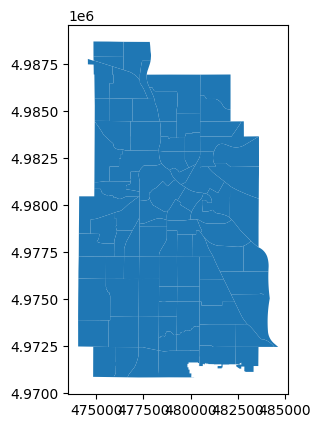

In [42]:
mpls_neighborhoods_df.plot()

### Filter Employment Data to 10 Year Increments

In [43]:
mpls_emp_df_2002 = df_merged.loc[(df_merged['Year'] == 2002)]
mpls_emp_df_2012 = df_merged.loc[(df_merged['Year'] == 2012)]
mpls_emp_df_2022 = df_merged.loc[(df_merged['Year'] == 2022)]

## Merge combined employment (primary), avg price of rice and flour (time series) with neighborhood data (geospatial)

In [44]:
geo_merge_df_2002 = pd.merge(mpls_emp_df_2002, mpls_neighborhoods_df, how='outer', left_on='Neighborhood', right_on='BDNAME')
# set the active geometry
geo_merge_df_2002 = geo_merge_df_2002.set_geometry("geometry")
#view the head
geo_merge_df_2002.head()

,Zipcode,Year,Total Employment in Zipcode,Total Establishments in Zipcode,Total Payroll in Zipcode,Employment for NAICS 722,Establishments for NAICS 722,Avg. Annual Wage for NAICS 722,Total Payroll for NAICS 722,Flour Avg Price per lb,...,INT_REFNO,PREFIX,UDI,SYMBOL_NAM,BDNAME,BDNUM,TEXT_NBR,SHAPE_Length,SHAPE_Area,geometry
0,"55401-04;15,54,87,88","2,002.00","142,347.00","4,462.00","8,143,669,190.00","8,185.00",369.00,"15,340.00","125,700,410.00",0.31,...,"-2,144,131,400.00",REFNO,23186.00,WARDAREA,North Loop,86,86,0.07,0.00,"MULTIPOLYGON (((478550.326 4982112.307, 478592..."
1,"55405,08,16","2,002.00","13,922.00","1,465.00","500,040,639.00",0.00,0.00,0.00,0.00,0.31,...,"-2,144,135,700.00",REFNO,23143.00,WARDAREA,Lowry Hill,43,43,0.06,0.00,"MULTIPOLYGON (((477293.021 4980440.894, 477292..."
2,55406,"2,002.00","6,155.00",419.00,"215,393,905.00",0.00,0.00,0.00,0.00,0.31,...,"-2,144,133,700.00",REFNO,23163.00,WARDAREA,Howe,63,63,0.08,0.00,"MULTIPOLYGON (((484138.698 4976477.210, 484136..."
3,55407,"2,002.00","4,010.00",324.00,"162,742,399.00",466.00,42.00,"12,792.00","5,956,071.00",0.31,...,"-2,144,134,500.00",REFNO,23155.00,WARDAREA,Powderhorn Park,55,55,0.06,0.00,"MULTIPOLYGON (((480482.625 4976064.000, 480482..."
4,"55409,10,19","2,002.00","9,343.00","1,176.00","266,852,787.00",883.00,66.00,"12,272.00","10,842,984.00",0.31,...,"-2,144,132,900.00",REFNO,23171.00,WARDAREA,King Field,71,71,0.06,0.00,"MULTIPOLYGON (((478327.523 4976072.079, 478327..."


In [45]:
geo_merge_df_2012 = pd.merge(mpls_emp_df_2012, mpls_neighborhoods_df, how='outer', left_on='Neighborhood', right_on='BDNAME')
# set the active geometry
geo_merge_df_2012 = geo_merge_df_2012.set_geometry("geometry")
#view the head
geo_merge_df_2012.head()

,Zipcode,Year,Total Employment in Zipcode,Total Establishments in Zipcode,Total Payroll in Zipcode,Employment for NAICS 722,Establishments for NAICS 722,Avg. Annual Wage for NAICS 722,Total Payroll for NAICS 722,Flour Avg Price per lb,...,INT_REFNO,PREFIX,UDI,SYMBOL_NAM,BDNAME,BDNUM,TEXT_NBR,SHAPE_Length,SHAPE_Area,geometry
0,"55401-04;15,54,87,88","2,012.00","154,014.00","4,284.00","11,567,873,852.00","9,460.00",416.00,"20,280.00","192,059,097.00",0.52,...,"-2,144,131,400.00",REFNO,23186.00,WARDAREA,North Loop,86,86,0.07,0.00,"MULTIPOLYGON (((478550.326 4982112.307, 478592..."
1,"55405,08,16","2,012.00","17,660.00","1,454.00","732,456,085.00","3,806.00",164.00,"18,304.00","69,644,617.00",0.52,...,"-2,144,135,700.00",REFNO,23143.00,WARDAREA,Lowry Hill,43,43,0.06,0.00,"MULTIPOLYGON (((477293.021 4980440.894, 477292..."
2,55406,"2,012.00","6,773.00",536.00,"225,661,072.00",930.00,53.00,"15,288.00","14,275,447.00",0.52,...,"-2,144,133,700.00",REFNO,23163.00,WARDAREA,Howe,63,63,0.08,0.00,"MULTIPOLYGON (((484138.698 4976477.210, 484136..."
3,55407,"2,012.00","4,462.00",348.00,"268,482,063.00",555.00,55.00,"17,524.00","9,751,158.00",0.52,...,"-2,144,134,500.00",REFNO,23155.00,WARDAREA,Powderhorn Park,55,55,0.06,0.00,"MULTIPOLYGON (((480482.625 4976064.000, 480482..."
4,"55409,10,19","2,012.00","6,993.00",896.00,"249,987,110.00",0.00,0.00,0.00,0.00,0.52,...,"-2,144,132,900.00",REFNO,23171.00,WARDAREA,King Field,71,71,0.06,0.00,"MULTIPOLYGON (((478327.523 4976072.079, 478327..."


In [46]:
geo_merge_df_2022 = pd.merge(mpls_emp_df_2022, mpls_neighborhoods_df, how='outer', left_on='Neighborhood', right_on='BDNAME')
# set the active geometry
geo_merge_df_2022 = geo_merge_df_2022.set_geometry("geometry")
#view the head
geo_merge_df_2022.head()

,Zipcode,Year,Total Employment in Zipcode,Total Establishments in Zipcode,Total Payroll in Zipcode,Employment for NAICS 722,Establishments for NAICS 722,Avg. Annual Wage for NAICS 722,Total Payroll for NAICS 722,Flour Avg Price per lb,...,INT_REFNO,PREFIX,UDI,SYMBOL_NAM,BDNAME,BDNUM,TEXT_NBR,SHAPE_Length,SHAPE_Area,geometry
0,"55401-04;15,54,87,88","2,022.00","153,292.00","4,379.00","17,291,375,031.00","7,993.00",403.00,"32,708.00","262,605,818.00",0.49,...,"-2,144,131,400.00",REFNO,23186.00,WARDAREA,North Loop,86,86,0.07,0.00,"MULTIPOLYGON (((478550.326 4982112.307, 478592..."
1,"55405,08,16","2,022.00","16,045.00","1,467.00","1,083,205,670.00",0.00,0.00,0.00,0.00,0.49,...,"-2,144,135,700.00",REFNO,23143.00,WARDAREA,Lowry Hill,43,43,0.06,0.00,"MULTIPOLYGON (((477293.021 4980440.894, 477292..."
2,55406,"2,022.00","8,333.00",730.00,"377,395,691.00","1,068.00",72.00,"27,144.00","29,030,047.00",0.49,...,"-2,144,133,700.00",REFNO,23163.00,WARDAREA,Howe,63,63,0.08,0.00,"MULTIPOLYGON (((484138.698 4976477.210, 484136..."
3,55407,"2,022.00","7,015.00",635.00,"512,076,518.00",691.00,78.00,"26,520.00","18,358,914.00",0.49,...,"-2,144,134,500.00",REFNO,23155.00,WARDAREA,Powderhorn Park,55,55,0.06,0.00,"MULTIPOLYGON (((480482.625 4976064.000, 480482..."
4,"55409,10,19","2,022.00","7,079.00","1,219.00","376,029,972.00",0.00,0.00,0.00,0.00,0.49,...,"-2,144,132,900.00",REFNO,23171.00,WARDAREA,King Field,71,71,0.06,0.00,"MULTIPOLYGON (((478327.523 4976072.079, 478327..."


### Plot NAICS 722 Establishment Counts as Centroids

##  2002
### Number of "food and drinking place" establishments by neighborhood 

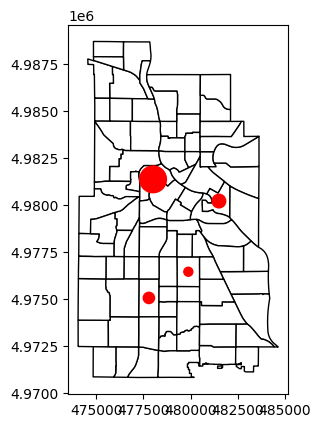

In [47]:
# add the centroids column
geo_merge_df_2002['neighborhood_centroid'] = geo_merge_df_2002.centroid

# set the base layer for multilayered map plot
base = geo_merge_df_2002.plot(color='white', edgecolor='black')

# plot 2002 NAICS 722 Establishments
geo_merge_df_2002['neighborhood_centroid'].plot(ax=base, marker='o', color='red', markersize=geo_merge_df_2002['Establishments for NAICS 722']);

##  2012
### Number of "food and drinking place" establishments by neighborhood 

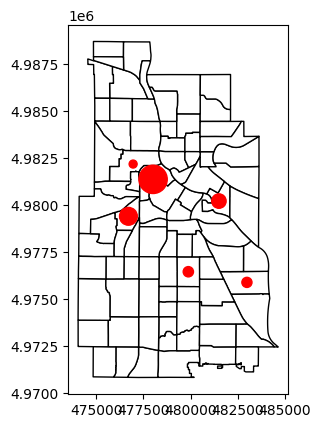

In [48]:
# add the centroids column
geo_merge_df_2012['neighborhood_centroid'] = geo_merge_df_2012.centroid

# set the base layer for multilayered map plot
base = geo_merge_df_2012.plot(color='white', edgecolor='black')

# plot 2012 NAICS 722 Establishments
geo_merge_df_2012['neighborhood_centroid'].plot(ax=base, marker='o', color='red', markersize=geo_merge_df_2012['Establishments for NAICS 722']);

##  2022
### Number of "food and drinking place" establishments by neighborhood 

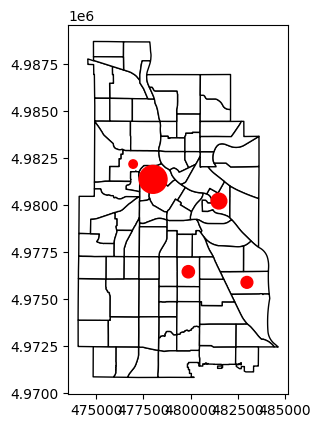

In [49]:
# add the centroids column
geo_merge_df_2022['neighborhood_centroid'] = geo_merge_df_2022.centroid

# set the base layer for multilayered map plot
base = geo_merge_df_2022.plot(color='white', edgecolor='black')

# plot 2012 NAICS 722 Establishments
geo_merge_df_2022['neighborhood_centroid'].plot(ax=base, marker='o', color='red', markersize=geo_merge_df_2022['Establishments for NAICS 722']);

## Plot NAICS 722 Establishment Avg Annual Wage as Centroids

##  2002
### Avg. Annual Wage of "food and drinking place" industry by neighborhood 

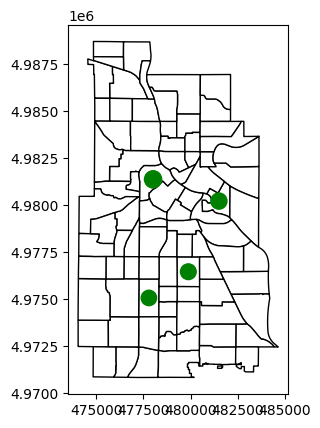

In [50]:
# add the centroids column
geo_merge_df_2002['neighborhood_centroid'] = geo_merge_df_2002.centroid

# set the base layer for multilayered map plot
base = geo_merge_df_2002.plot(color='white', edgecolor='black')

# plot 2002 NAICS 722 Avg Annual Wage
geo_merge_df_2002['neighborhood_centroid'].plot(ax=base, marker='o', color='green', markersize=geo_merge_df_2002['Avg. Annual Wage for NAICS 722']/100);

##  2012
### Avg. Annual Wage of "food and drinking place" industry by neighborhood 

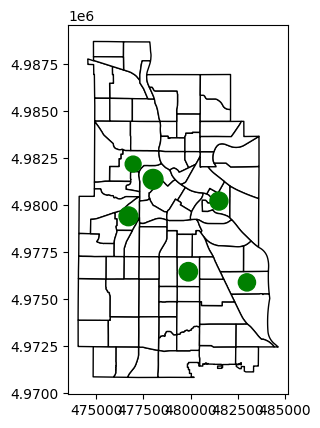

In [51]:
# add the centroids column
geo_merge_df_2012['neighborhood_centroid'] = geo_merge_df_2012.centroid

# set the base layer for multilayered map plot
base = geo_merge_df_2012.plot(color='white', edgecolor='black')

# plot 2012 NAICS 722 Avg Annual Wage
geo_merge_df_2012['neighborhood_centroid'].plot(ax=base, marker='o', color='green', markersize=geo_merge_df_2012['Avg. Annual Wage for NAICS 722']/100);

##  2022
### Avg. Annual Wage of "food and drinking place" industry by neighborhood 

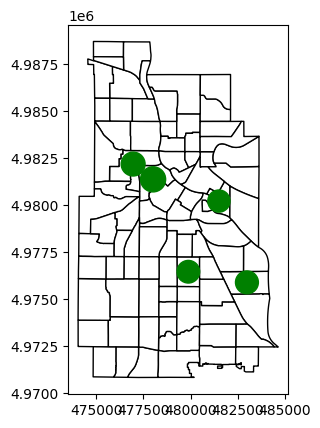

In [52]:
# add the centroids column
geo_merge_df_2022['neighborhood_centroid'] = geo_merge_df_2022.centroid

# set the base layer for multilayered map plot
base = geo_merge_df_2022.plot(color='white', edgecolor='black')

# plot 2012 NAICS 722 Avg Annual Wage
geo_merge_df_2022['neighborhood_centroid'].plot(ax=base, marker='o', color='green', markersize=geo_merge_df_2022['Avg. Annual Wage for NAICS 722']/100);